# Analysis of the telco customer churn data

## Prepare the work setup

In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

## Load the dataset


In [2]:
# Enter the file name
file_name = 'telco_customer_churn_data.csv'

In [3]:
# construct the absolute path to the file and print it
import os
os.getcwd()
file_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', file_name))
print(file_path)

# Check if file exists
print(os.path.exists(file_path))

c:\Users\MNET\projects\ifs-challenge\data\telco_customer_churn_data.csv
True


## Exploratory data analysis (EDA)

In [4]:
# Load the data
data = pd.read_csv(file_path, sep=';')
# Show head preview of the data
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
# Print summary of the data frame and its columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### Inspect columns by type
Let's have a closer look at each column by its type.

In [6]:
# Define as function for later reuse
def inspect_columns_by_type(data):
    print('-' * 40)
    print("Inspect each non-numeric column's unique values and number of missing values")
    print('-' * 40)

    for col in data.columns:
        if data[col].dtype == 'object':
            print(f'{col}: unique={data[col].unique()}, missing={data[col].isnull().sum()}')


    print('-' * 40)
    print("Inspect each integer column's range of values and number of missing values")
    print('-' * 40)
    for col in data.columns:
        if data[col].dtype == 'int64':
            print(f'{col}: min={data[col].min()}, max={data[col].max()}, unique={data[col].unique()}, missing={data[col].isnull().sum()}')


    print('-' * 40)
    print("Inspect each float column's range of values and number of missing values")
    print('-' * 40)
    for col in data.columns:
        if data[col].dtype == 'float64':
            print(f'{col}: min={data[col].min()}, max={data[col].max()}, missing={data[col].isnull().sum()}')

In [7]:
# First inspection (before any data cleaning)
inspect_columns_by_type(data)

----------------------------------------
Inspect each non-numeric column's unique values and number of missing values
----------------------------------------
customerID: unique=['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK'], missing=0
gender: unique=['Female' 'Male'], missing=0
Partner: unique=['Yes' 'No'], missing=0
Dependents: unique=['No' 'Yes'], missing=0
PhoneService: unique=['No' 'Yes'], missing=0
MultipleLines: unique=['No phone service' 'No' 'Yes'], missing=0
InternetService: unique=['DSL' 'Fiber optic' 'No'], missing=0
OnlineSecurity: unique=['No' 'Yes' 'No internet service'], missing=0
OnlineBackup: unique=['Yes' 'No' 'No internet service'], missing=0
DeviceProtection: unique=['No' 'Yes' 'No internet service'], missing=0
TechSupport: unique=['No' 'Yes' 'No internet service'], missing=0
StreamingTV: unique=['No' 'Yes' 'No internet service'], missing=0
StreamingMovies: unique=['No' 'Yes' 'No internet service'], missing=0
Contract: unique=[

### Conclusions and basic feature engineering

1. Obvious binary columns that need mapping to `{0, 1}` values:
    * `gender: ['Female' 'Male']`
    * `Partner: ['Yes' 'No']`
    * `Dependents: ['No' 'Yes']`
    * `PhoneService: ['No' 'Yes']`
    * `PaperlessBilling: ['Yes' 'No']`
    * `Churn: ['No' 'Yes']`
    
1. Columns that may be used as binary as well but there is a dependency to the column `InternetService` in the case where its value is `'No'`: Then all values are `'No internet service'` for the following columns:
    * `OnlineSecurity: ['No' 'Yes' 'No internet service']`
    * `OnlineBackup: ['Yes' 'No' 'No internet service']`
    * `DeviceProtection: ['No' 'Yes' 'No internet service']`
    * `TechSupport: ['No' 'Yes' 'No internet service']`
    * `StreamingTV: ['No' 'Yes' 'No internet service']`
    * `StreamingMovies: ['No' 'Yes' 'No internet service']`
    
    Similarly, the column `MultipleLines` has a dependency to the column `PhoneService` in the case where its value is `'No'`: Then all values of `MultipleLines` is `'No phone service'`:
    * `MultipleLines: ['No phone service' 'No' 'Yes']`


=> Map all `'Yes'` (and `'Female'`) values to `1` and map `'No'` / `'No xxx service'` and `'Male'` values to `0`:

In [137]:
# Transform to binary value range {0, 1}
binary_features = [
    'gender',
    'Partner',
    'Dependents',
    'PhoneService',
    'PaperlessBilling',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies',
    'MultipleLines'
]
data[binary_features] = data[binary_features].map(lambda x: 1 if (x == 'Yes' or x == 'Female') else 0)

# Churn is the target variable, also binary to transform to {0, 1}
data['Churn'] = data['Churn'].map(lambda x: 1 if x == 'Yes' else 0)

3. Categorical columns that could also be transformed to scalars: 
    * `Contract: unique=['Month-to-month' 'One year' 'Two year']`

        => Map `Contract` category values into their corresponding numeric meanings in years.

    * `InternetService: unique=['DSL' 'Fiber optic' 'No']`
    
        => Map `InternetService` category values into their scalars in terms of higher (performance / speed) is better, 0 equals none.


In [9]:
# Map: 0 (Month-to-month), 1 (One year), 2 (Two year)
data['Contract'] = data['Contract'].map(lambda x: 2 if x == 'Two year' else 1 if x == 'One year' else 0)

# Map: 0 (No Internet Service), 1 (DSL), 2 (Fiber optic)
data['InternetService'] = data['InternetService'].map(lambda x: 2 if x == 'Fiber optic' else 1 if x == 'DSL' else 0)

4. Columns that have missing values:
    * `TotalCharges: min=18.8, max=8684.8, missing=11`
        => Let's drop these 11 lines:

In [10]:
# drop the data with missing values in TotalCharges
data = data.dropna(subset=['TotalCharges'])

5. Columns to drop completely because they are neither features nor target variables
    ```
    * customerID: unique=['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD' '3186-AJIEK']
    ```

In [11]:
# Drop customerID
data = data.drop(columns=['customerID'])

### Final inspection
Inspect the columns again and make sure everything is as expected:

In [12]:
# Second inspection (after data cleaning)
inspect_columns_by_type(data)

----------------------------------------
Inspect each non-numeric column's unique values and number of missing values
----------------------------------------
PaymentMethod: unique=['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)'], missing=0
----------------------------------------
Inspect each integer column's range of values and number of missing values
----------------------------------------
gender: min=0, max=1, unique=[1 0], missing=0
SeniorCitizen: min=0, max=1, unique=[0 1], missing=0
Partner: min=0, max=1, unique=[1 0], missing=0
Dependents: min=0, max=1, unique=[0 1], missing=0
tenure: min=1, max=72, unique=[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39], missing=0
PhoneService: min=0, max=1, unique=[0 1], missing=0
MultipleLines: min=0, max=1, unique=[0 1], missing=

### Plots

In [55]:
# Distribution plots after cleaning
def distribution_plots(data, dtype):
    plt.figure(figsize=(20, 30))
    j = 0
    for i, column in enumerate(data.columns):
        data_dtype = data[column].dtype

        # overwrite data_dtype if column is binary
        if data[column].nunique() == 2:
            data_dtype = 'binary'

        if data_dtype == dtype:
            plt.subplot(len(data.columns) // 3 + 1, 3, j + 1)
            if dtype == 'object' or dtype == 'binary':
                # the countplot is used for categorical data and binary data, add the Churn as hue
                sns.countplot(x=column, data=data, hue='Churn')
                title = f"{column} (Count: {dtype})"
            else:
                # the histogram is used for numerical data (int64 and float64), add the Churn as hue
                sns.histplot(data, x=column, hue='Churn', element='step')
                title = f"{column} (Histogram: {dtype})"
            plt.title(title)
            j += 1
    plt.tight_layout()
    plt.show()

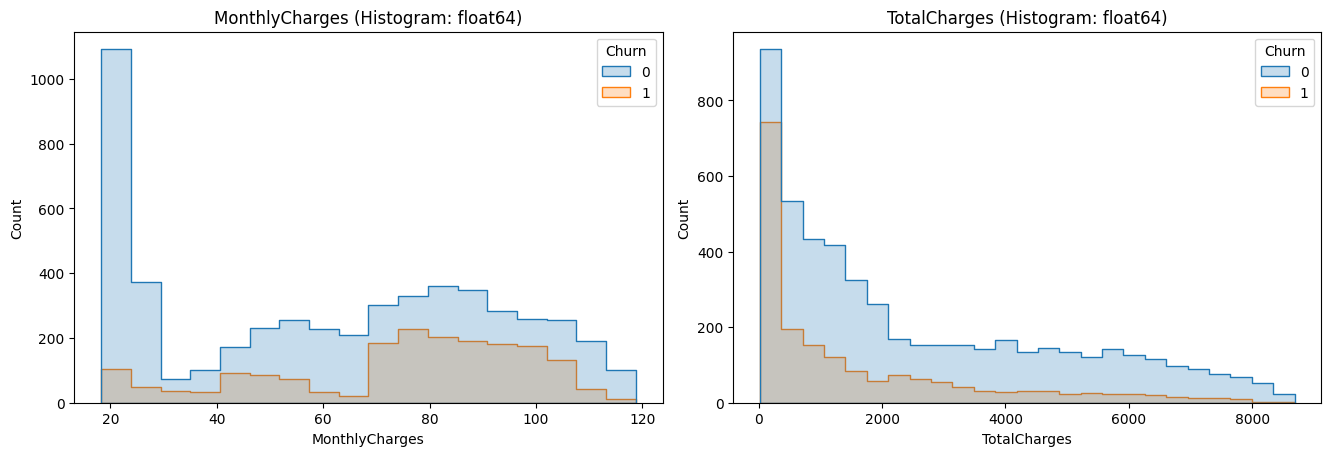

In [56]:
# Distribution plots for scalar features
distribution_plots(data, 'float64')

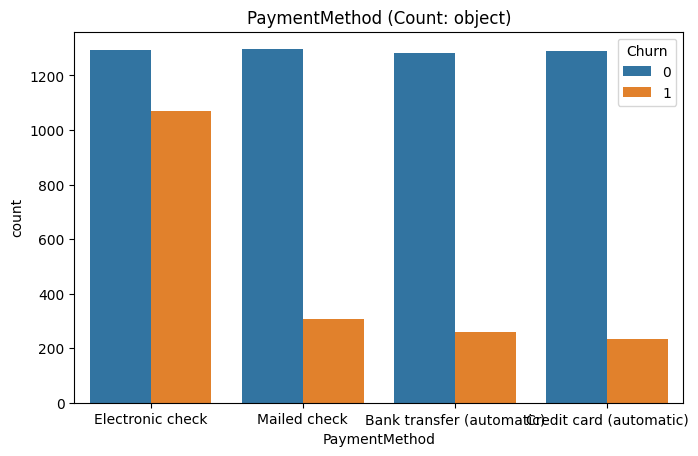

In [57]:
# Distribution plots for categorical features
distribution_plots(data, 'object')

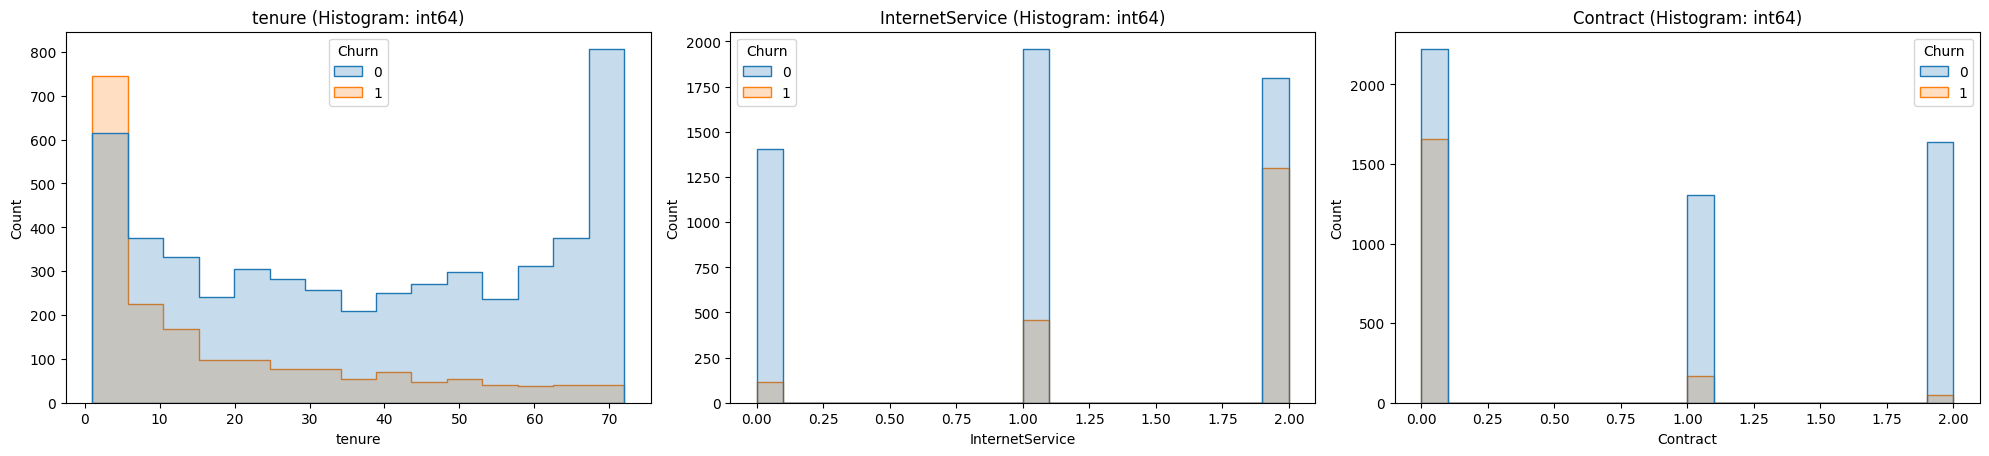

In [54]:
# Distribution plots for non-binary (integer valued) features
distribution_plots(data, 'int64')

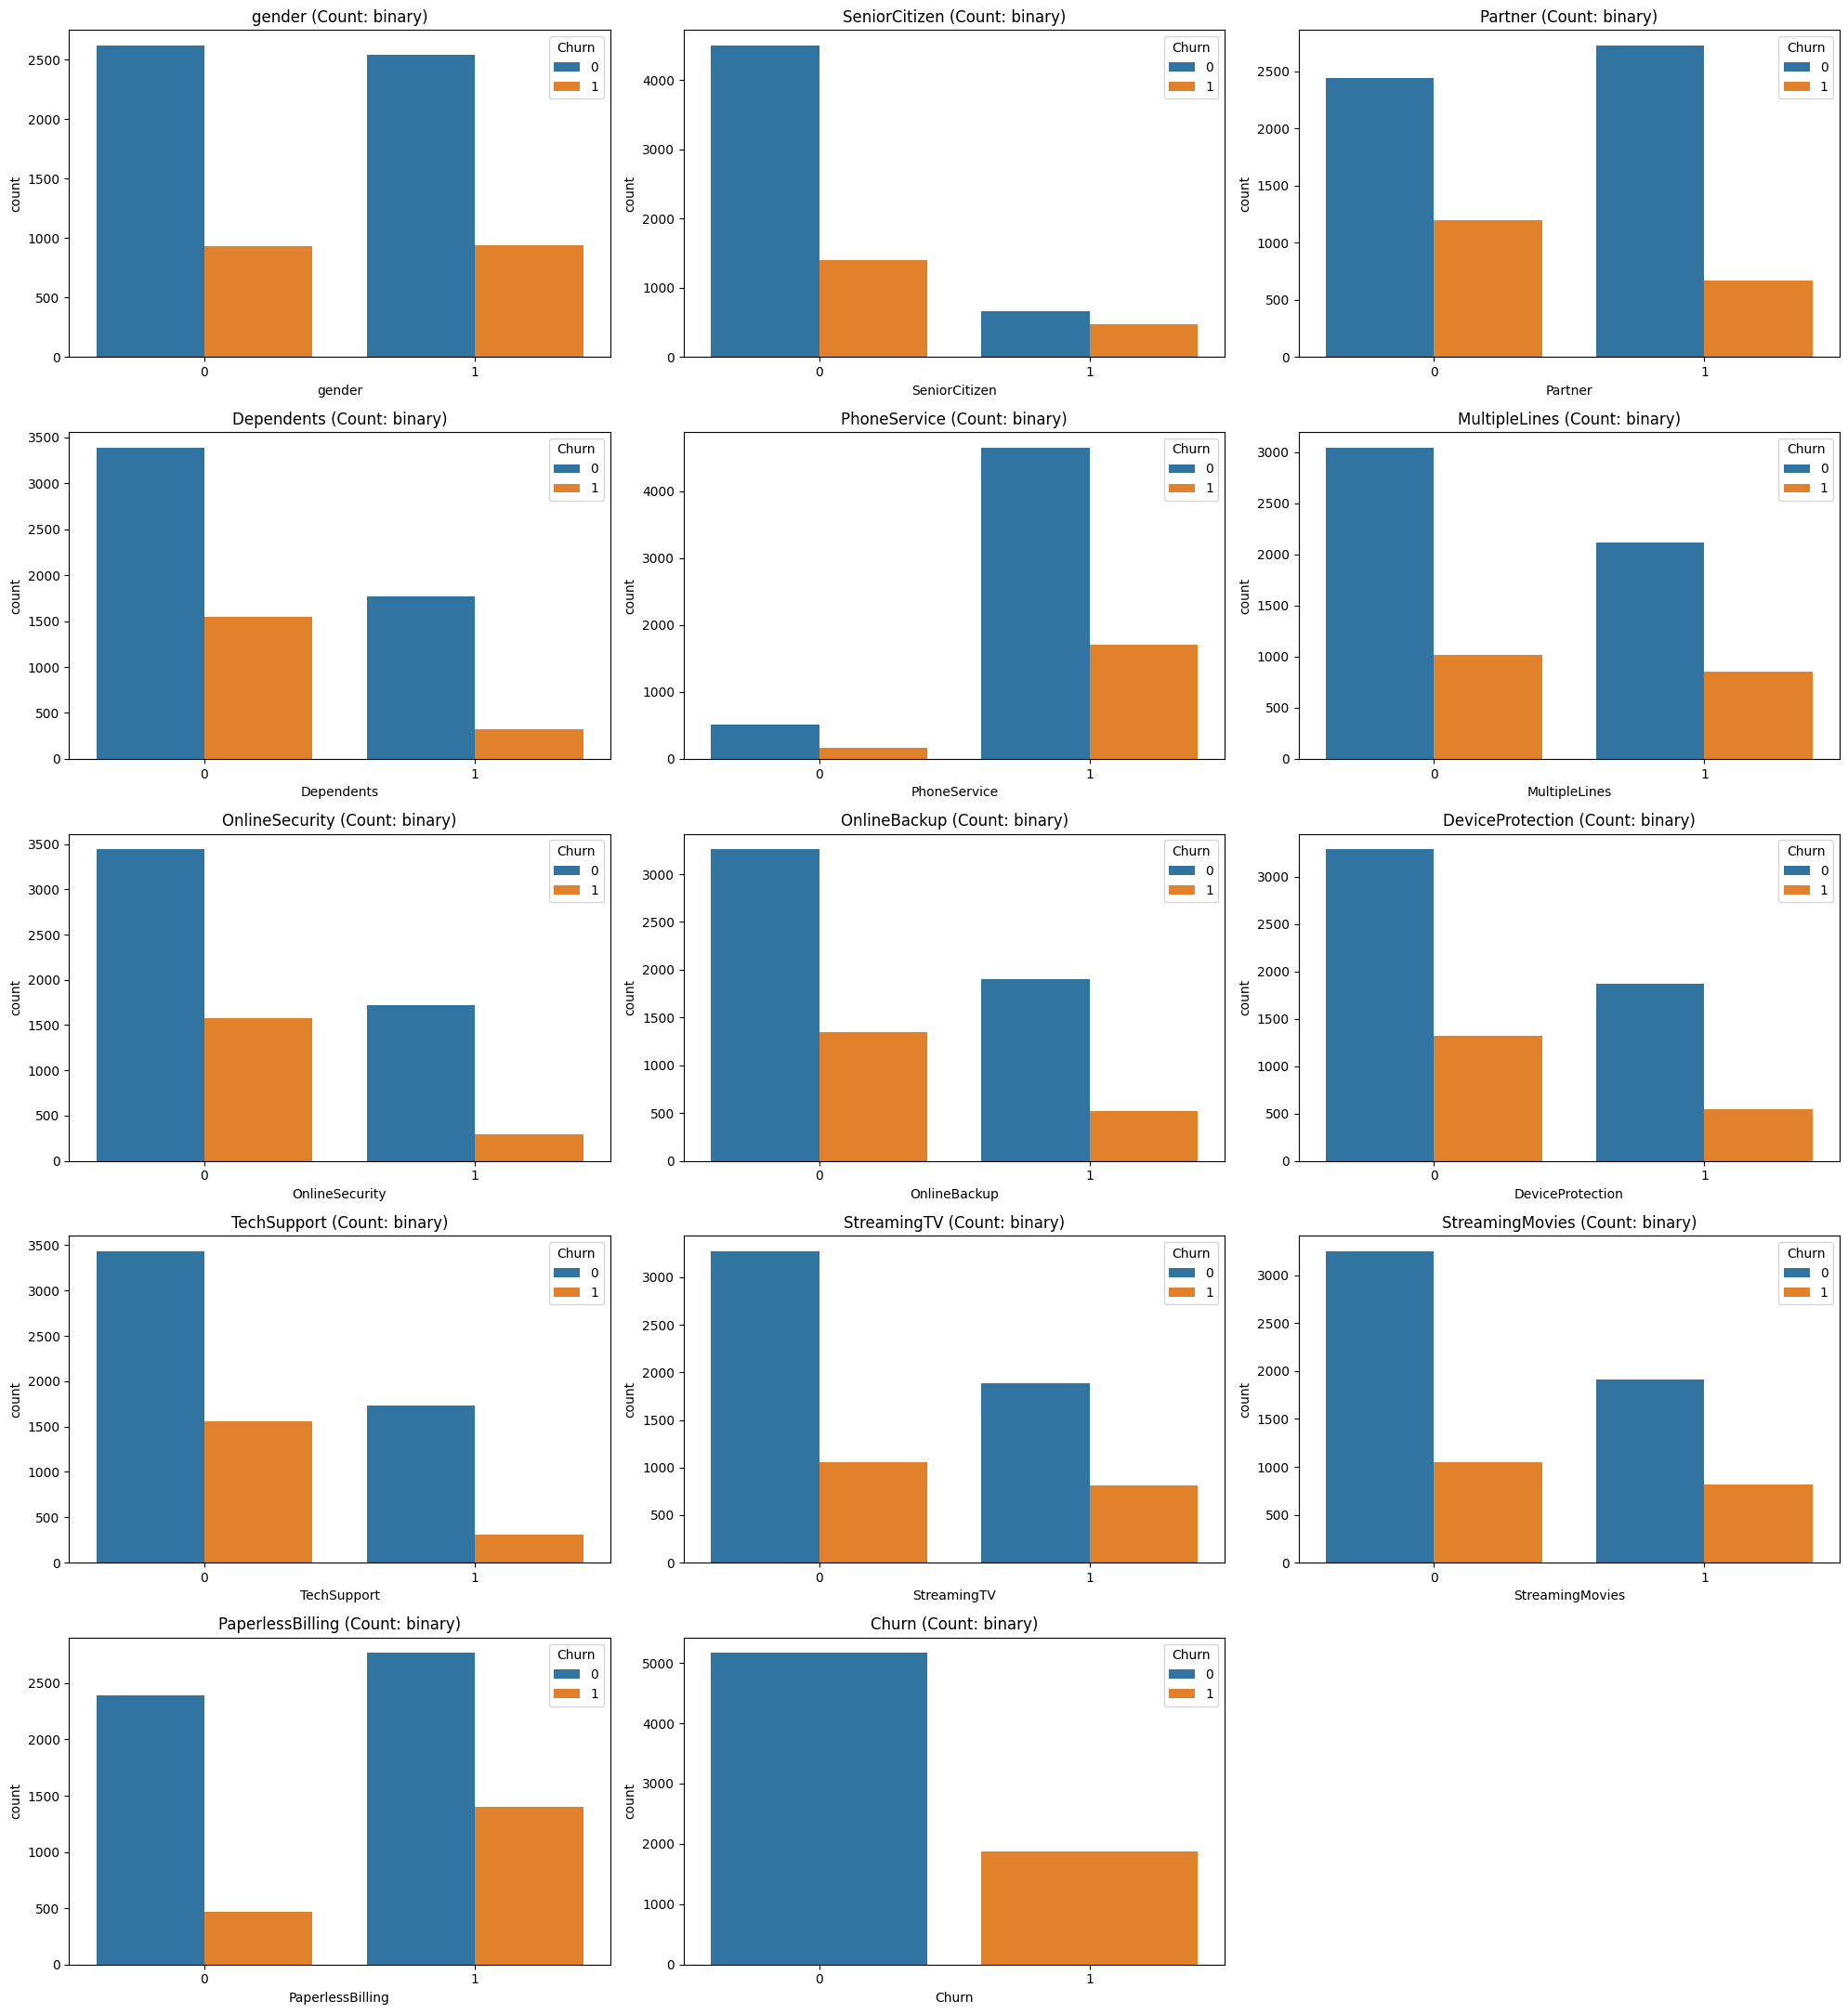

In [58]:
# Distribution plots for binary features
distribution_plots(data, 'binary')

### Mutual relation between the features and the target

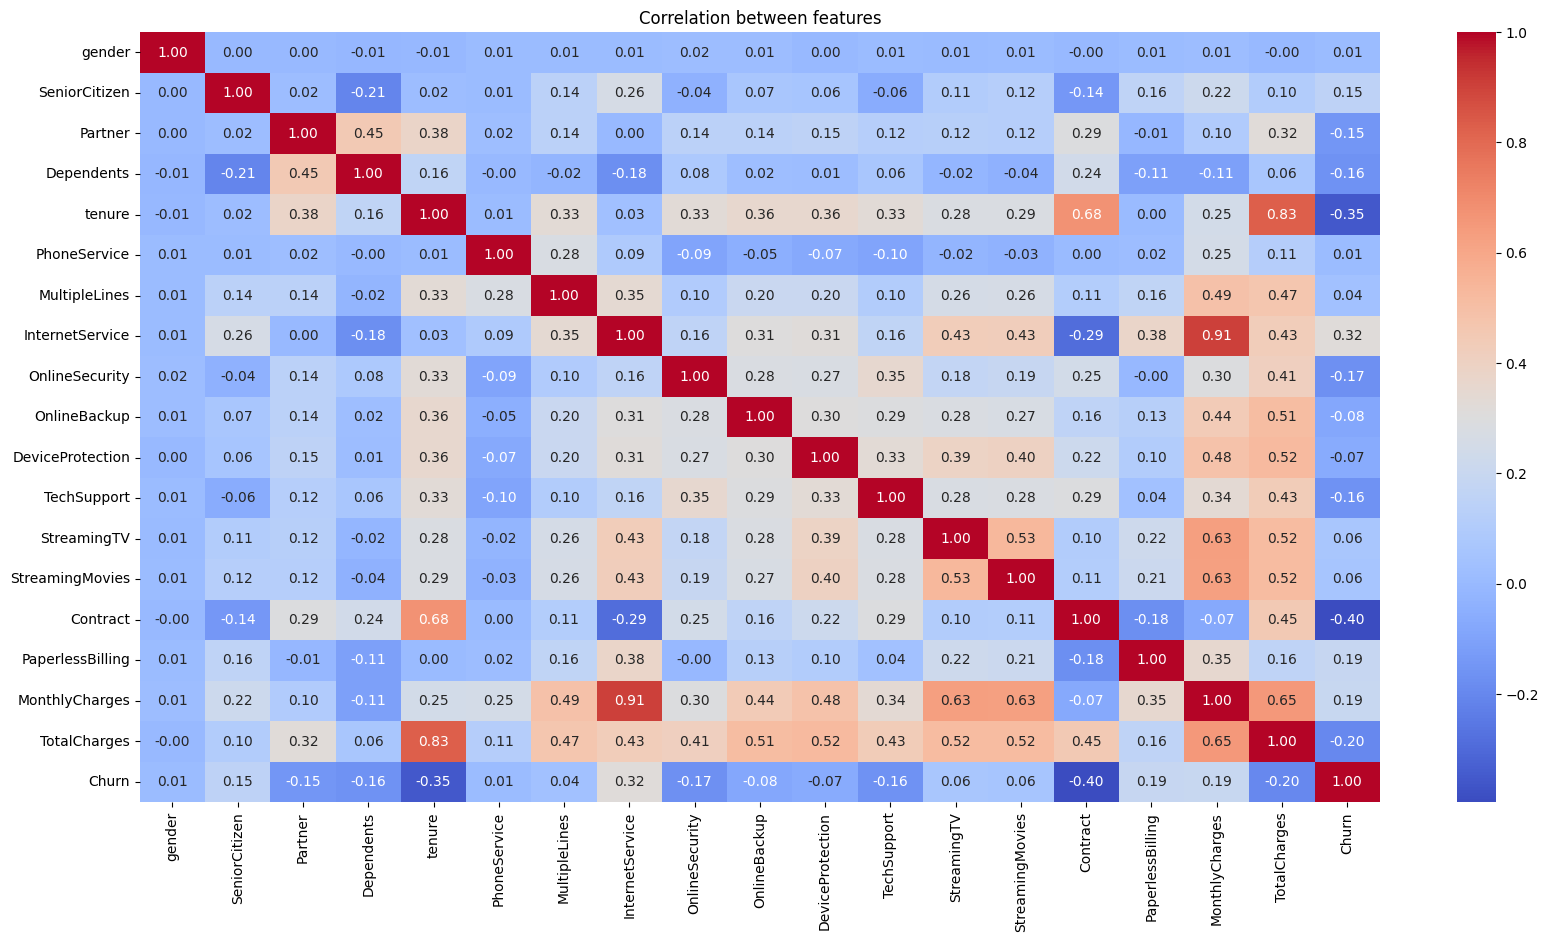

In [64]:
# Analyze the correlation between the features (except PaymentMethod) and the target variable (except PaymentMethod)
plt.figure(figsize=(20, 10))
sns.heatmap(data.drop('PaymentMethod', axis=1).corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation between features')
plt.show()

# For PaymentMethod, see the plots below the heatmap

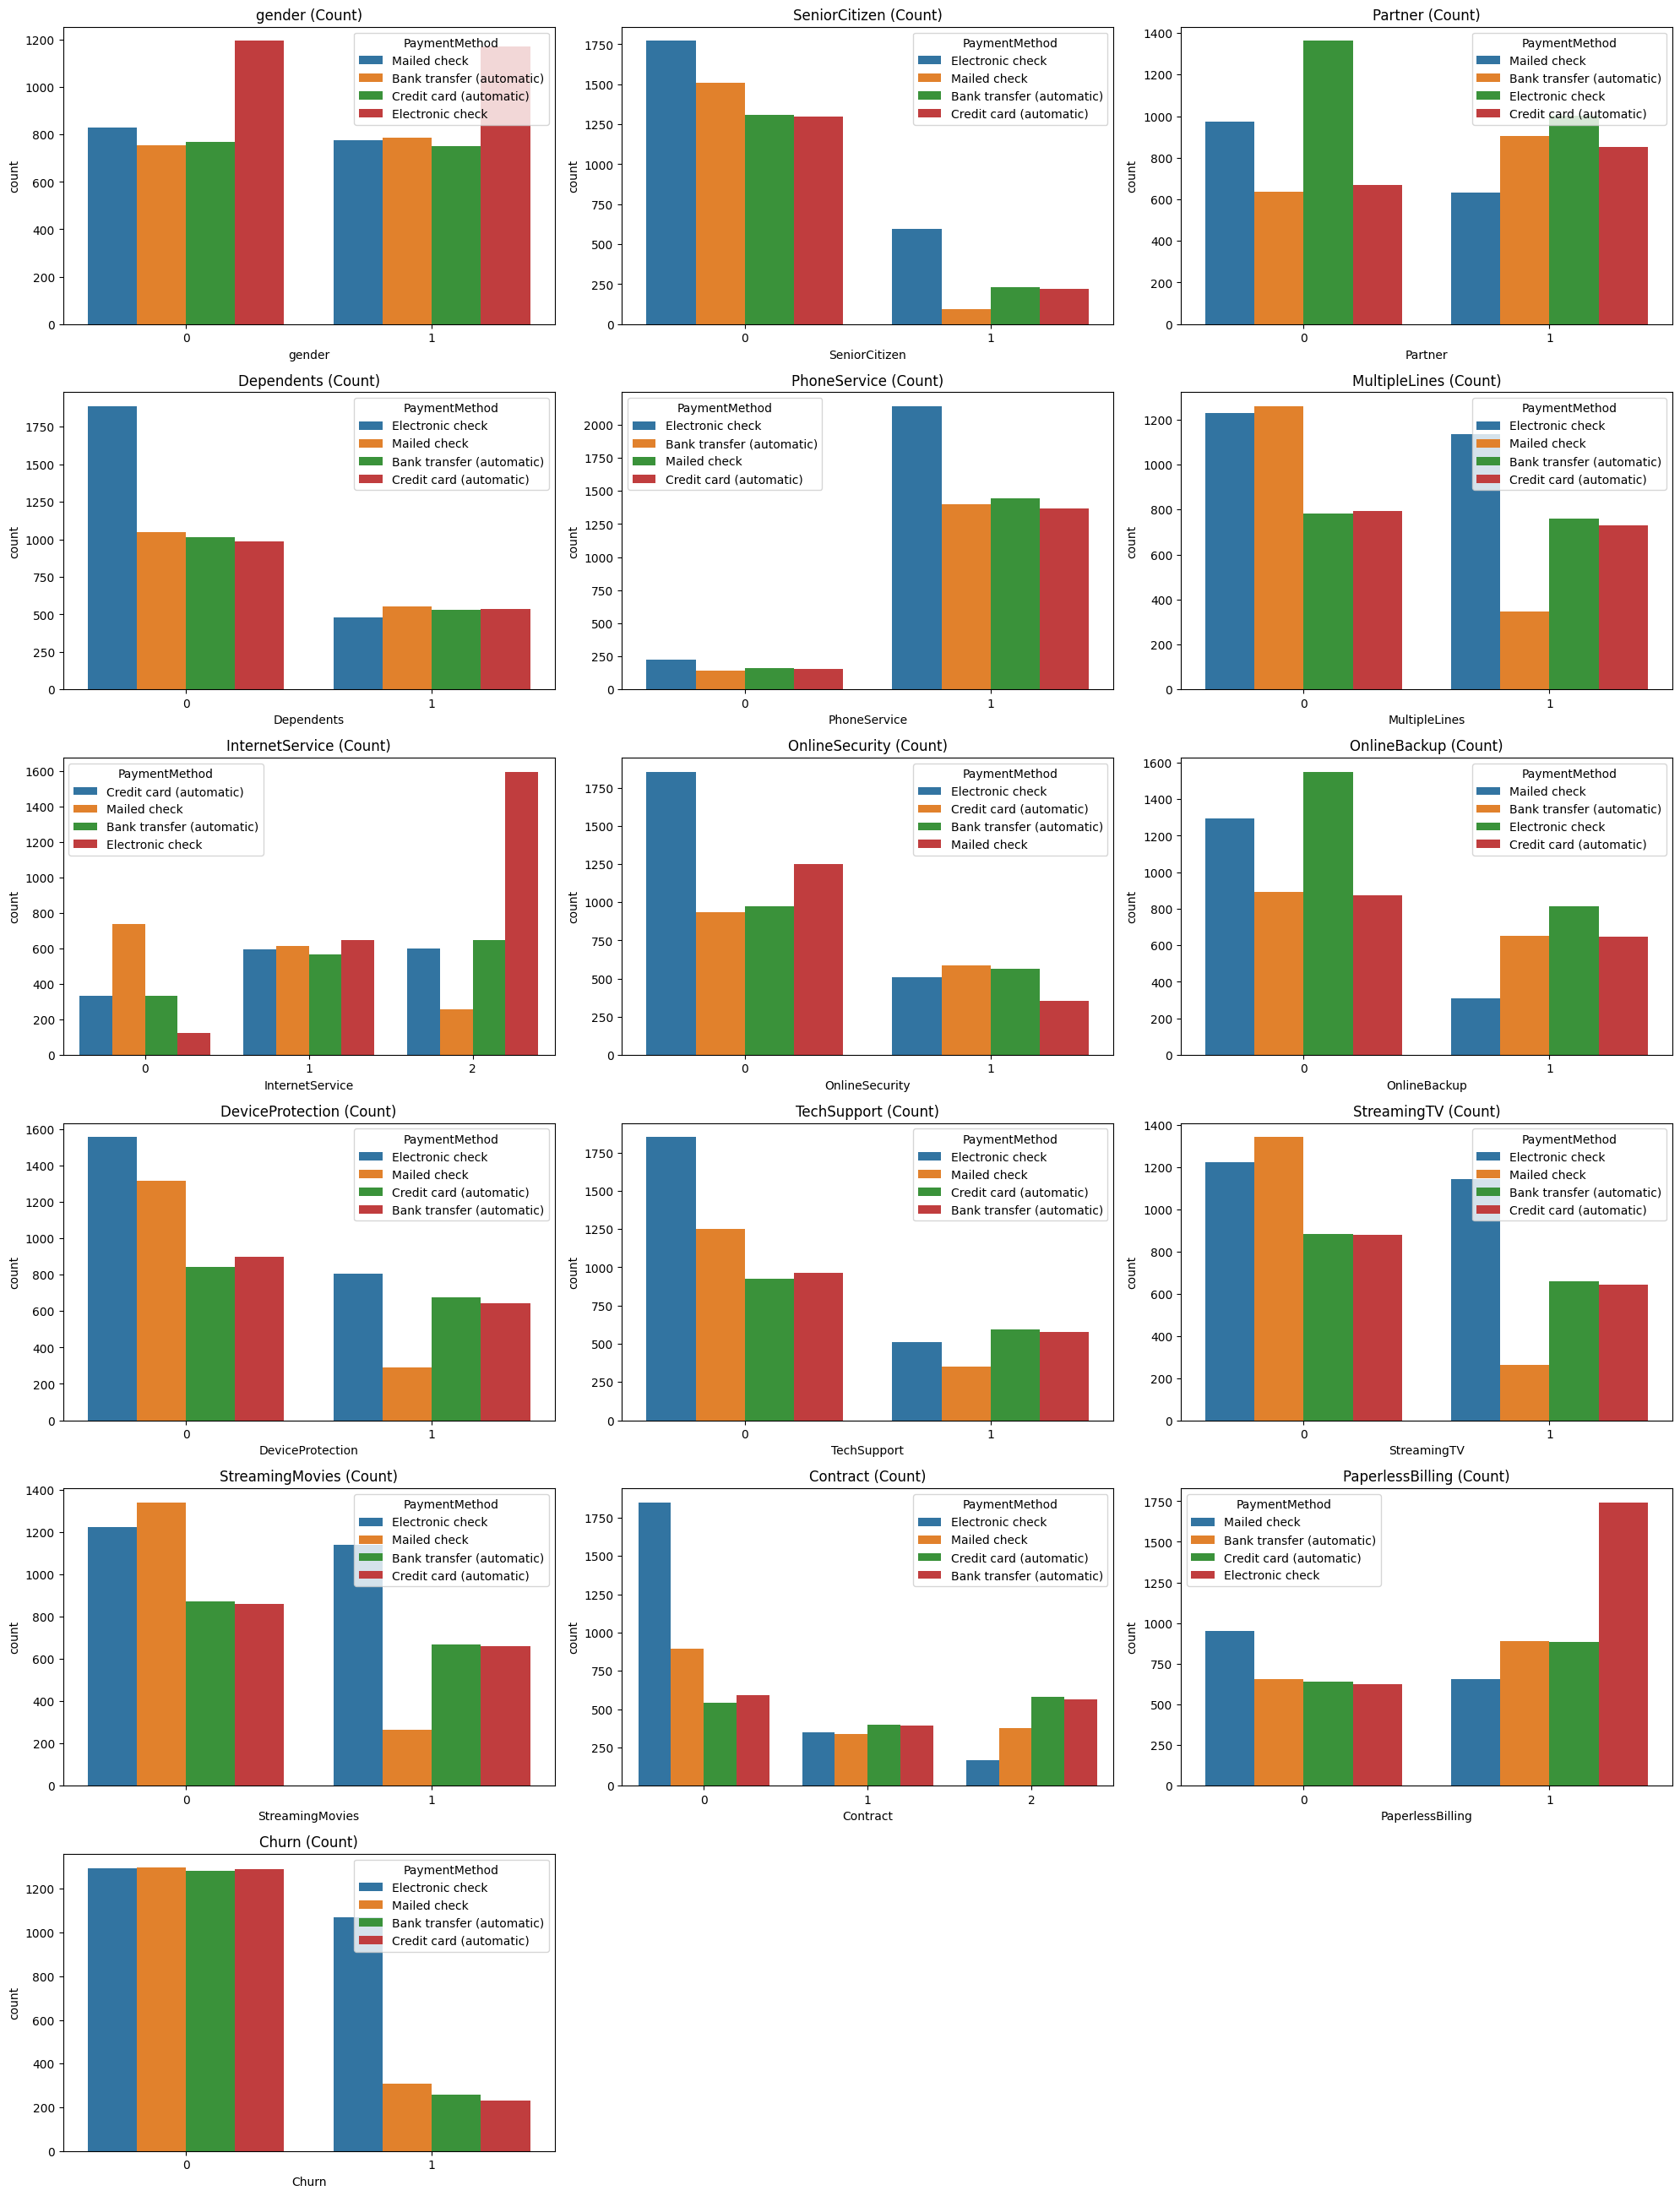

In [75]:
# Count plot of all binary or ternary features, with 'PaymentMethod' as hue
plt.figure(figsize=(20, 30))
j = 0
for i, column in enumerate(data.columns):
    if data[column].dtype == 'int64' and data[column].nunique() <= 3:
        plt.subplot(len(data.columns) // 3 + 1, 3, j + 1)
        sns.countplot(x=column, data=data, hue='PaymentMethod')
        plt.title(f"{column} (Count)")
        j += 1
plt.tight_layout()
plt.show()


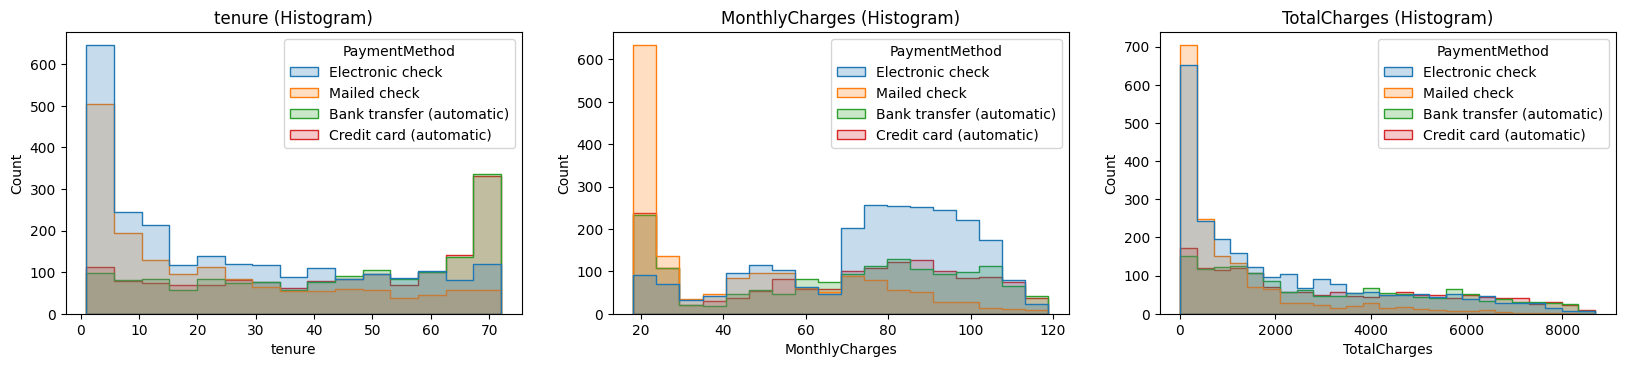

In [76]:
# Histogram of all remaining features, with 'PaymentMethod' as hue
plt.figure(figsize=(20, 30))
j = 0
for i, column in enumerate(data.columns):
    if data[column].dtype == 'float64' or (data[column].dtype == 'int64' and data[column].nunique() > 3):
        plt.subplot(len(data.columns) // 3 + 1, 3, j + 1)
        sns.histplot(data, x=column, hue='PaymentMethod', element='step')
        plt.title(f"{column} (Histogram)")
        j += 1

Comments:
* Churn seems to be correlated (correlation coefficient's absolute value above 0.1)
    * **negatively** with `tenure` and `Contract`: The longer the person has been a customer of the company), the less likely they will churn.
    * **negatively** with the binary features `Partner`, `Dependents`, `OnlineSecurity`, `TechSupport`: Churn is less likely if their value is `'No'`
    * **positively** with the binary features `SeniorCitizen`, `InternetService`, `PaperlessBilling`: Churn is less likely if their value is `'Yes'`
    * **negatively** with the scalar feature `TotalCharges`: The lower the total charges, the more frequently customers tend to churn.
    * **positively** with the scalar feature `MonthlyCharges`: The higher the monthly charges, the more likely customers churn.
* Churn seems to be uncorrelated (i.e. the coefficients absolute value is not more than 0.1) with
    * `gender`
    * `PhoneService`
    * `MultipleLines`
    * `OnlineBackup`
    * `DeviceProtection`
    * `StreamingTV`
    * `StreamingMovies`
* For the categorical feature `PaymentMethod` it seems that customers with `'Electronic check'` are less likely to churn than with other payment methods.
* In addition, some features seem to be highly correlated (absolute value > 0.5) with each other, for instance:
    * `TotalCharges` and:
        * `tenure`
        * `MonthlyCharges`
        * `OnlineBackup`
        * `DeviceProtection`
        * `StreamingTV`
        * `StreamingMovies`
    * Further, `tenure` and `Contract`
    * Further, `Partner` and `Dependents`
    * Further, `MonthlyCharges` and:
        * `InternetService`
        * `StreamingTV`
        * `StreamingMovies`
    * Further, `StreamingTV` and `StreamingMovies`


Let's now conclude the exploratory analysis and continue with the classification modelling.

## Classification modelling

### Split data into features and target

In [82]:
# Features
X = data.drop('Churn', axis=1)
# Target
y = data['Churn']

### Preprocessing

#### Categorical Features
The only remaining categorical features to be **one-hot encoded** are:
```
* PaymentMethod: unique=['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
```

In [19]:
categorical_features = [
    'PaymentMethod',
]

#### Numerical Features
The remaining numerical features to be **normalized** are:
```
* MonthlyCharges: min=18.25, max=118.75
* TotalCharges: min=18.8, max=8684.8
* Contract: min=0, max=2, unique=[0 1 2]
* tenure: min=1, max=72, unique=[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
```

In [20]:
numerical_features = [
    'MonthlyCharges',
    'TotalCharges',
    'Contract',
    'tenure',
]

#### Define the preprocessor

In [138]:
# Encode the categorical features and scale the numerical features into [0, 1] interval, and leave the binary features unchanged
preprocessor = ColumnTransformer(
    transformers=[
        # categorical features are encoded using OneHotEncoder
        ('cat', OneHotEncoder(drop='first'), categorical_features),
        # numerical features are scaled using MinMaxScaler
        ('num', MinMaxScaler(), numerical_features),
        # binary features are left unchanged
        ('bin', 'passthrough', binary_features)
    ]
)

### Train / test split

In [129]:
from sklearn.model_selection import train_test_split
# Perform the train-test split preserving the ratio of the target variable, using a fixed seed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# Preserve the dataframe structure
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)


### Training pipeline setup

In [130]:
# Initiate a sklearn pipeline
from sklearn.pipeline import Pipeline

# Try different classifiers
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Feature selection
from sklearn.feature_selection import SelectKBest, chi2

# Grid search and metrics for hyperparameter tuning
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    make_scorer,
    roc_auc_score,
    roc_curve,
    auc,
    f1_score,
    precision_score,
    recall_score
)

In [231]:

# Define the full pipeline with feature selection and classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=chi2, k=10)),
    ('classifier', LogisticRegression())  # Default classifier, will be changed in grid search
])


Our model candidates:
* Logistic Regression
* Random Forest
* Gradient Boosting
* XGBoost
* Support Vector Machine (linear kernel)
* Support Vector Machine (rbf-kernel)

In [232]:

# Define parameter grids for each classifier
param_grids = {
    'logistic_regression': {
        'classifier': [LogisticRegression()],
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__penalty': ['l2']
    },
    'random_forest': {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20],
    },
    'gradient_boosting': {
        'classifier': [GradientBoostingClassifier()],
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.1, 0.01],
    },
    'xgboost': {
        'classifier': [XGBClassifier()],
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.1, 0.01],
    },
    'svm_linear': {
        'classifier': [SVC(kernel='linear')],
        'classifier__C': [0.1, 1.0, 10.0],
    },
    'svm_rbf': {
        'classifier': [SVC(kernel='rbf')],
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__gamma': ['scale', 'auto'],
    }
}


# Combine all parameter grids into one for grid search
combined_param_grid = []
for key, params in param_grids.items():
    combined_param_grid.append(params)



In [233]:
# Define the metrics
metrics = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'roc_auc': make_scorer(roc_auc_score)
}

### Perform the training with cross-validation

In [234]:
# Perform grid search
grid_search = GridSearchCV(
    pipeline,
    combined_param_grid,
    scoring=metrics,
    refit='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit the grid search
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 26 candidates, totalling 130 fits


c:\Users\MNET\projects\ifs-challenge\.venv\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['PaymentMethod']),
                                                                        ('num',
                                                                         MinMaxScaler(),
                                                                         ['MonthlyCharges',
                                                                          'TotalCharges',
                                                                          'Contract',
                                                                          'tenure']),
                                                                        ('bin',
                                                                         'passthrough',
                                                                         ['gender',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'PhoneService',
                                                                          'PaperlessBilling',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'Device...
                          'classifier__gamma': ['scale', 'auto']}],
             refit='roc_auc',
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'f1': make_scorer(f1_score, response_method='predict'),
                      'precision': make_scorer(precision_score, response_method='predict'),
                      'recall': make_scorer(recall_score, response_method='predict'),
                      'roc_auc': make_scorer(roc_auc_score, response_method='predict')},
             verbose=2)

### Evaluate the best model

In [246]:
# Print best model and CV score
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best model: \n")
print("\t* ", "\n\t* ".join(
    [
        "{:<{width}}{}".format(
            (key if key == 'classifier' else key.replace('classifier__','')) + ':',
            value.__class__.__name__ if key == 'classifier' else value,
            width=20)
        for key, value in best_params.items()
    ]),
    sep="")
print("\t* {:<{width}}{:.2f}".format("CV score:", best_score, width=20))

Best model: 

	* classifier:         GradientBoostingClassifier
	* learning_rate:      0.1
	* n_estimators:       200
	* CV score:           0.70


In [247]:
# Print selected features
selected_features_idx = best_model.named_steps['feature_selection'].get_support(indices=True)
selected_features_names = X_train.columns[selected_features_idx]
print("Selected features: \n")
print("\t* ", "\n\t* ".join(selected_features_names.values), "\n", sep="")

Selected features: 

	* gender
	* SeniorCitizen
	* tenure
	* PhoneService
	* MultipleLines
	* OnlineSecurity
	* OnlineBackup
	* TechSupport
	* StreamingTV
	* PaperlessBilling



Using the best model, get the predicted classes, then print classification report and the confusion matrix. Then plot the ROC curve.

Classification Report: 

              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1033
           1       0.60      0.48      0.53       374

    accuracy                           0.78      1407
   macro avg       0.71      0.68      0.69      1407
weighted avg       0.77      0.78      0.77      1407
 

Confusion Matrix: 

          Predicted 0  Predicted 1
Actual 0          916          117
Actual 1          195          179 


ROC curve plot:


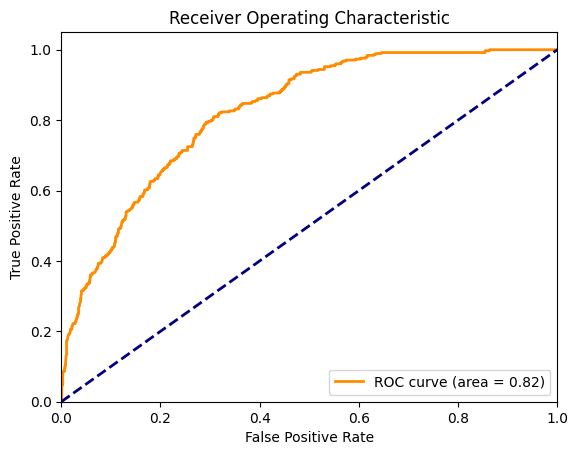

In [248]:
# Predict on the test set
y_pred = grid_search.predict(X_test)

# Print classification report 
print("Classification Report: \n")
print(classification_report(y_test, y_pred), "\n")

# Print confusion matrix
print("Confusion Matrix: \n")
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])
print(confusion_matrix_df, "\n\n")

# Plot ROC curve
print("ROC curve plot:")
fpr, tpr, thresholds = roc_curve(y_test, grid_search.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Let's have a look at the feature importances:

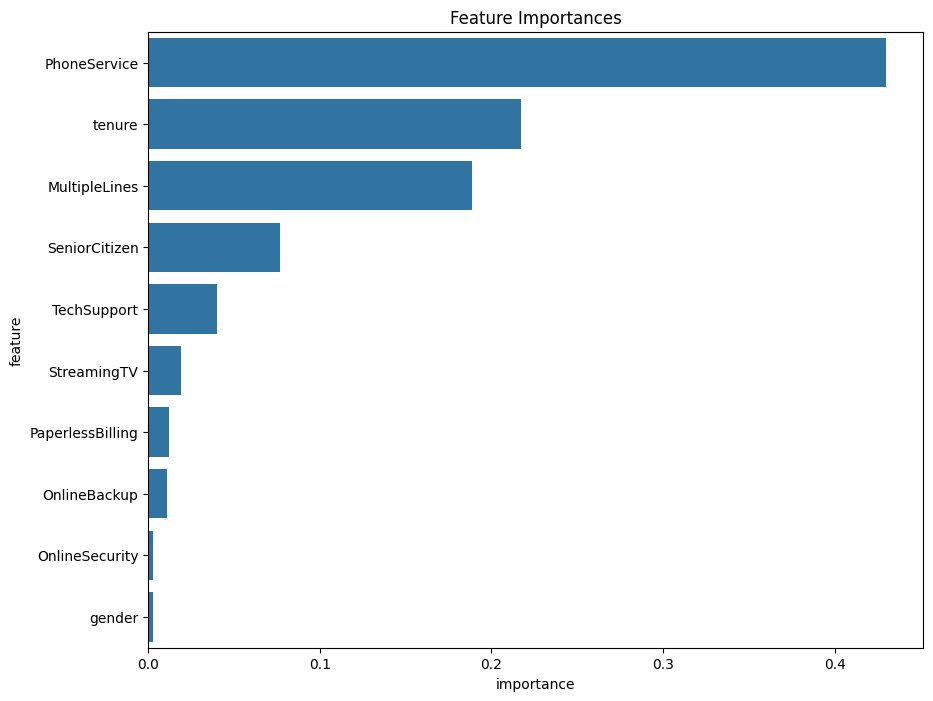

In [249]:
# Feature importance analysis
best_model = grid_search.best_estimator_

if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    importances = best_model.named_steps['classifier'].feature_importances_
    feature_importance_df = pd.DataFrame({'feature': selected_features_names, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
elif hasattr(best_model.named_steps['classifier'], 'coef_'):
    importances = best_model.named_steps['classifier'].coef_[0]
    feature_importance_df = pd.DataFrame({'feature': selected_features_names, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
else:
    raise ValueError("The best classifier does not provide feature importances or coefficients")

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance_df, x='importance', y='feature')
plt.title('Feature Importances')
plt.show()

### Save the best model

In [252]:
import joblib

# construct the absolute path to the file and print it
import os
os.getcwd()
save_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'models', 'bestmodel.joblib'))
print(save_path)

joblib.dump(best_model, save_path)


c:\Users\MNET\projects\ifs-challenge\models\bestmodel.joblib


['c:\\Users\\MNET\\projects\\ifs-challenge\\models\\bestmodel.joblib']